Let us predict who is earning more than 50.000 dollar.
Those people will be eligible to stay at our XXX lounge.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shap.datasets import adult  # shap is only used as dataset utility


In [31]:
X, y_true = adult()
X.columns = [col.lower() for col in X.columns]
X.head()

,age,workclass,education-num,marital status,occupation,relationship,race,sex,capital gain,capital loss,hours per week,country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


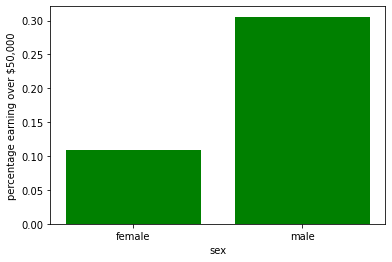

In [32]:
y_true = y_true * 1 
sex = X['sex'].apply(lambda sex: "female" if sex == 0 else "male")

def percentage_with_label_1(sex_value):
    return y_true[sex == sex_value].sum() / (sex == sex_value).sum()


plt.bar([0, 1], 
        [percentage_with_label_1("female"), percentage_with_label_1("male")], 
        color='g')
plt.xticks([0, 1], ["female", "male"])
plt.ylabel("percentage earning over $50,000")
plt.xlabel("sex")
plt.show()

### Fit an unaware model

In [33]:
from sklearn.linear_model import LogisticRegression
numeric_columns = ['age', 'capital gain', 'education-num', 'capital loss', 'hours per week']

classifier = LogisticRegression()
classifier.fit(X[numeric_columns], y_true)

y_pred = classifier.predict(X[numeric_columns])
y_prob = classifier.predict_proba(X[numeric_columns])

## Evaluate the fit

In [34]:
from fairlearn.metrics import group_summary
from sklearn.metrics import accuracy_score
group_summary(accuracy_score, y_true, y_pred, sensitive_features=sex)


{'overall': 0.8144713000214981,
 'by_group': {'female': 0.8914678302850246, 'male': 0.7764111977971546}}

In [35]:
from fairlearn.metrics import selection_rate, ratio_from_summary
selection_rate_summary = group_summary(selection_rate, y_true, y_pred, sensitive_features=sex)
selection_rate_summary

{'overall': 0.13433248364607966,
 'by_group': {'female': 0.07817287159966577, 'male': 0.16209270307480494}}

In [36]:
ratio_from_summary(selection_rate_summary)
# Thus one group is twice as much selected as the other

0.4822726138609052

In [37]:
from fairlearn.metrics import equalized_odds_difference

equalized_odds_difference(y_true, y_pred, sensitive_features=sex)
# Thus the probability barely of true positive and false negative barely changes if the protetected attribute 
# changes value

0.03810644550421938

In [38]:
from fairlearn.metrics import true_positive_rate, false_negative_rate, false_positive_rate, true_negative_rate

tp = group_summary(true_positive_rate, y_true, y_pred, sensitive_features=sex)
fn = group_summary(false_negative_rate, y_true, y_pred, sensitive_features=sex)
fp = group_summary(false_positive_rate, y_true, y_pred, sensitive_features=sex)
tn = group_summary(true_negative_rate, y_true, y_pred, sensitive_features=sex)


def flatten_group_summary(group_summary_dict):
    dict_flattened = {k: v for (k, v) in group_summary_dict.get('by_group').items()}
    dict_flattened.update({'overall':  group_summary_dict.get('overall')})
    return dict_flattened

def create_df_summaries(summary_function, tp, fp, fn, tn):
    df = pd.DataFrame.from_dict({
        'True positive': summary_function(tp),
        'False positive': summary_function(fp),
        'False negative': summary_function(fn),
        'True negative': summary_function(tn),
    }, orient='index')
    return df

create_df_summaries(flatten_group_summary, tp, fp, fn, tn)



,female,male,overall
True positive,0.361323,0.399430,0.393700
False positive,0.043369,0.057575,0.052063
False negative,0.638677,0.600570,0.606300
True negative,0.956631,0.942425,0.947937


In [39]:
create_df_summaries(ratio_from_summary, tp, fp, fn, tn)


,0
True positive,0.904598
False positive,0.753265
False negative,0.940335
True negative,0.985150


In [40]:
from fairlearn.metrics import equalized_odds_ratio
equalized_odds_ratio(y_true, y_pred, sensitive_features=sex)


0.7532645363673709

In [41]:
# Accuracy (TP + TN)/ All: The model is better at assesing most appropriate category of women
# Balanced accuracy: If the smallest category (positive) gets more weight, weighed accuracy approx the same
# Precision TP/ (TP + FP): More women (+/- 50%) vs men (+/- 25%) are wrongly chosen for the True category
# Recall TP/ (TP + FN): More women are forgot
# Selection rate (TP + FP)/ P: Men are twice as likely to be selected

from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features=sex,
                   sensitive_feature_names=['sex'],
                   y_true=y_true,
                   y_pred={"initial model": y_pred})

FairlearnWidget(value={'true_y': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1…

In [79]:
from fairlearn.postprocessing._threshold_optimizer import _reformat_and_group_data
from fairlearn.postprocessing._roc_curve_utilities import _calculate_roc_points, _filter_points_to_get_convex_hull
from fairlearn.postprocessing._roc_curve_utilities import _get_roc,  _interpolate_curve
def get_roc_points(data_grouped_by_sensitive_feature):

    roc_points = {}
    for group_name, group in data_grouped_by_sensitive_feature:
        roc_points[group_name] = _calculate_roc_points(
            data_grouped_by_sensitive_feature.get_group(group_name), 0
        )
    return roc_points

def plot_roc(data_grouped_by_sensitive_feature, roc_points, **kwargs):
    
    
    for group_name, group in data_grouped_by_sensitive_feature:
        plt.plot(roc_points[group_name].x, roc_points[group_name].y, label=group_name)

    plt.xlabel("$P [ \\hat{Y}=1 | Y=0 ]$")
    plt.ylabel("$P [ \\hat{Y}=1 | Y=1 ]$")
    plt.legend()    


In [43]:
os.listdir('/Users/bertwassink/opt/anaconda3/envs/fairtalk/lib/python3.7/site-packages/fairlearn/postprocessing/')

['_constants.py',
 '_threshold_optimizer.py',
 '_roc_curve_utilities.py',
 '__init__.py',
 '_plotting.py',
 '__pycache__',
 '_interpolated_prediction.py',
 '_threshold_operation.py']

In [106]:
!cat '/Users/bertwassink/opt/anaconda3/envs/fairtalk/lib/python3.7/site-packages/fairlearn/postprocessing/_roc_curve_utilities.py'

# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import numpy as np
import pandas as pd

from ._constants import LABEL_KEY, SCORE_KEY, P0_KEY, P1_KEY
from ._threshold_operation import ThresholdOperation

DEGENERATE_LABELS_ERROR_MESSAGE = "Degenerate labels for sensitive feature value {}"


def _get_roc(data, sensitive_feature_value, flip=True):
    """Get ROC curve's convex hull based on data columns 'score' and 'label'.

    Scores represent output values from the predictor.

    :param data: the DataFrame containing scores and labels
    :type data: pandas.DataFrame
    :param sensitive_feature_value: the sensitive feature value of the samples provided in `data`
    :type sensitive_feature_value: str or int
    :param flip: if True flip points below the ROC diagonal into points above by applying negative
        weights; if False does not allow flipping; default True
    :type flip: bool
    :return: the convex hull over the ROC curve poi

In [104]:
data_grouped_by_sensitive_feature_before = _reformat_and_group_data(
    sex, y_true, y_prob[:,1]
)
data_grouped_by_sensitive_feature_before.head()

,sensitive_feature,score,label
0,male,0.473005,0
1,male,0.194624,0
2,male,0.104516,0
3,male,0.103037,0
4,female,0.219682,0
5,female,0.363684,0
6,female,0.018860,0
7,male,0.205415,1
8,female,0.983302,1
12,female,0.132158,0


In [46]:
data_grouped_by_sensitive_feature_before.get_group('male').head()

,sensitive_feature,score,label
0,male,0.473005,0
1,male,0.194624,0
2,male,0.104516,0
3,male,0.103037,0
7,male,0.205415,1


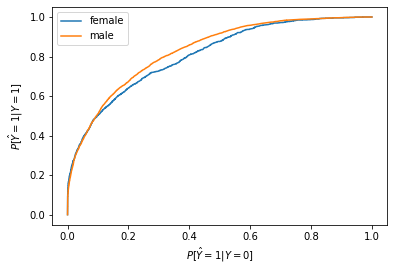

In [47]:
roc_points_before = get_roc_points(data_grouped_by_sensitive_feature_before)
plt1 = plot_roc(data_grouped_by_sensitive_feature_before, roc_points_before)


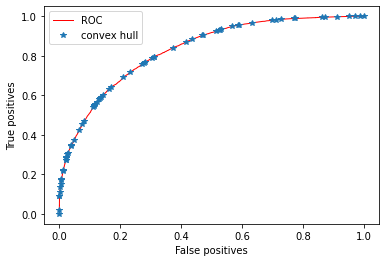

In [48]:
roc_points_before = get_roc_points(data_grouped_by_sensitive_feature_before)
roc_sorted = roc_points_before.get('male')
roc_selected = _filter_points_to_get_convex_hull(roc_sorted)
roc_convex_hull = pd.DataFrame(roc_selected)[['x', 'y', 'operation']]
# y 

plt.plot(roc_sorted['x'],
         roc_sorted['y'],
         marker='',
         linewidth=1,
         linestyle='-',
         c='red',
         label='ROC')
plt.plot(roc_convex_hull['x'],
         roc_convex_hull['y'],
         marker='*',
         
         linestyle='',
         label='convex hull'
        )
plt.xlabel('False positives')
plt.ylabel('True positives')
plt.legend()
plt.show()

In [84]:
grid = np.linspace(0, 1, 100 + 1)

In [105]:
print('a')

a


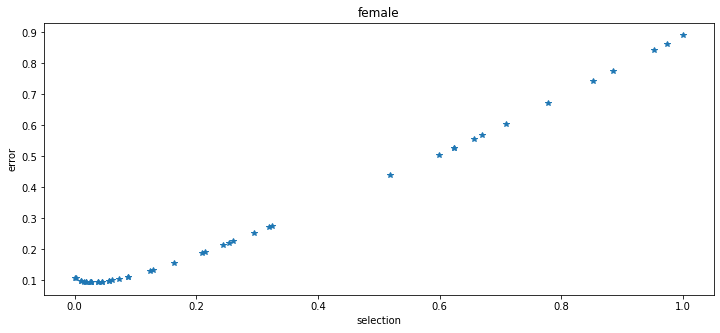

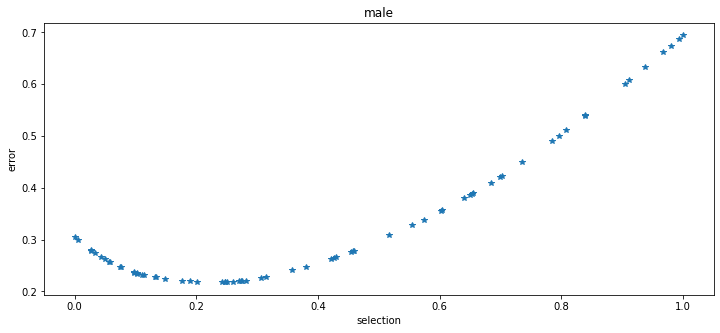

In [96]:
n = X.shape[0]
overall_tradeoff_curve = 0
selection_error_curve = {}
for name, group  in data_grouped_by_sensitive_feature_before:
    n_group = len(group)
    n_positive = sum(group['label'])
    n_negative = n_group - n_positive
    p_sensitive_feature_value = n_group / n
    
    roc_convex_hull = _get_roc(group, name, flip=False)
    
    fraction_negative_label_positive_sample = (
        n_negative / n_group) * roc_convex_hull['x']
    fraction_positive_label_positive_sample = (
        n_positive / n_group) * roc_convex_hull['y']
    # Calculate selection to represent the proportion of positive predictions.
    roc_convex_hull['selection'] = fraction_negative_label_positive_sample + \
        fraction_positive_label_positive_sample

    fraction_positive_label_negative_sample = \
        (n_positive / n_group) * (1 - roc_convex_hull['y'])
    roc_convex_hull['error'] = fraction_negative_label_positive_sample + \
        fraction_positive_label_negative_sample
    
    selection_error_curve[name] = \
                _interpolate_curve(roc_convex_hull, 'selection', 'error', 'operation', grid)
    
    overall_tradeoff_curve += p_sensitive_feature_value * \
                selection_error_curve[name]['error']
    
    
    plt.plot(roc_convex_hull['selection'],
             roc_convex_hull['error'],
             marker='*',
             linestyle='',
             label='convex hull'
            )

    plt.xlabel('selection')
    plt.ylabel('error')
    plt.title(name)
    plt.show()

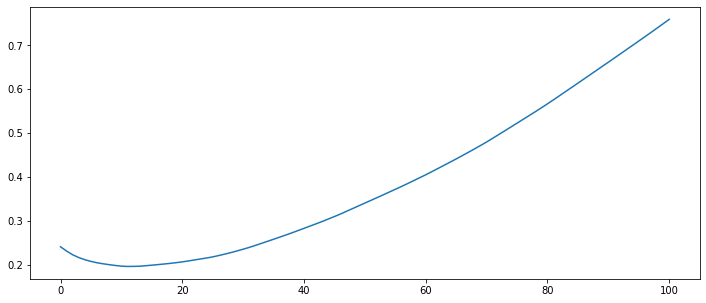

In [99]:
overall_tradeoff_curve.plot()

In [ ]:
n_group = len(group)
n_positive = sum(group[LABEL_KEY])
n_negative = n_group - n_positive
p_sensitive_feature_value = n_group / n

roc_convex_hull = _get_roc(group, sensitive_feature_value, flip=flip)

fraction_negative_label_positive_sample = (
    n_negative / n_group) * roc_convex_hull['x']
fraction_positive_label_positive_sample = (
    n_positive / n_group) * roc_convex_hull['y']
# Calculate selection to represent the proportion of positive predictions.
roc_convex_hull['selection'] = fraction_negative_label_positive_sample + \
    fraction_positive_label_positive_sample

fraction_positive_label_negative_sample = \
    (n_positive / n_group) * (1 - roc_convex_hull['y'])
roc_convex_hull['error'] = fraction_negative_label_positive_sample + \
    fraction_positive_label_negative_sample

self._selection_error_curve[sensitive_feature_value] = \
    _interpolate_curve(roc_convex_hull, 'selection', 'error', 'operation',
                       self._x_grid)


## Mitigate disparity using postprocessing

In [49]:
from fairlearn.postprocessing import ThresholdOptimizer

estimator = LogisticRegression(solver="liblinear")


from sklearn import clone
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError


class LogisticRegressionAsRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, logistic_regression_estimator):
        self.logistic_regression_estimator = logistic_regression_estimator

    def fit(self, X, y):
        try:
            check_is_fitted(self.logistic_regression_estimator)
            self.logistic_regression_estimator_ = self.logistic_regression_estimator
        except NotFittedError:
            self.logistic_regression_estimator_ = clone(
                self.logistic_regression_estimator
            ).fit(X, y)
        return self
    def predict(self, X):
        # use predict_proba to get real values instead of 0/1, select only prob for 1
        scores = self.logistic_regression_estimator_.predict_proba(X)[:, 1]
        return scores


estimator_wrapper = LogisticRegressionAsRegression(estimator).fit(X[numeric_columns], y_true)
postprocessed_predictor_DP = ThresholdOptimizer(
    estimator=estimator_wrapper, constraints="demographic_parity", prefit=True
)

postprocessed_predictor_DP.fit(
    X[numeric_columns], y_true, sensitive_features=sex
)

fairness_aware_predictions_DP_train = postprocessed_predictor_DP.predict(
    X[numeric_columns], sensitive_features=sex
)
# fairness_aware_predictions_EO_test = postprocessed_predictor_EO.predict(
#     X_test, sensitive_features=sensitive_features_test
# )



In [50]:
FairlearnDashboard(sensitive_features=sex,
                   sensitive_feature_names=['sex'],
                   y_true=y_true,
                   y_pred={
                       "initial model": y_pred, 
                       "mitigated_model": fairness_aware_predictions_DP_train
                          })


FairlearnWidget(value={'true_y': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1…

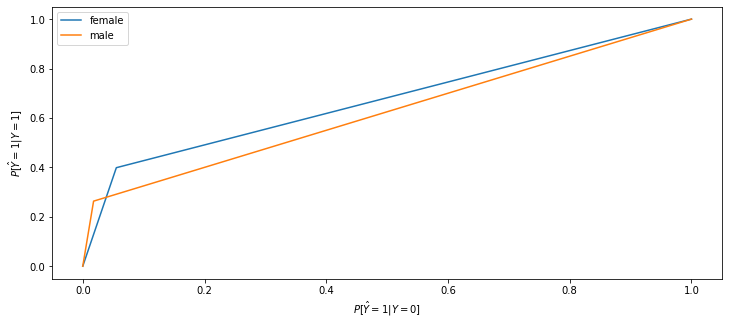

In [53]:
data_grouped_by_sensitive_feature_mitigated = _reformat_and_group_data(
    sex, y_true, fairness_aware_predictions_DP_train
)
roc_points_mitigated = get_roc_points(data_grouped_by_sensitive_feature_mitigated)
plot_roc(data_grouped_by_sensitive_feature_mitigated, 
                roc_points_mitigated)


In [54]:
for (
    group,
    interpolation,
) in postprocessed_predictor_DP._post_processed_predictor_by_sensitive_feature.items():
    print("{}:".format(group))
    print("\n ".join(interpolation.__repr__().split(",")))
    print("-----------------------------------")

female:
[p_ignore: 0
  prediction_constant: 0
  p0: 0.6808456790123454
  operation0: [>0.3990724816295724]
  p1: 0.3191543209876546
  operation1: [>0.37484824726283017]]
-----------------------------------
male:
[p_ignore: 0
  prediction_constant: 0
  p0: 0.9622709163346609
  operation0: [>0.5719704303505535]
  p1: 0.037729083665339114
  operation1: [>0.5337162460232734]]
-----------------------------------


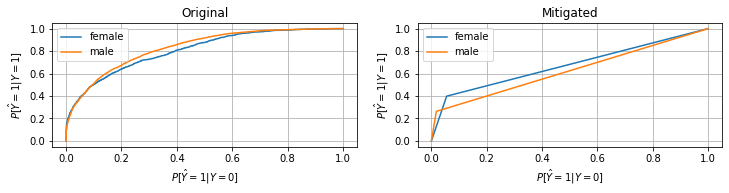

In [55]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 5)

plt.subplot(221)
plot_roc(data_grouped_by_sensitive_feature_before, 
                roc_points_before)
plt.grid(True)
plt.title("Original")

plt.subplot(222)
plot_roc(data_grouped_by_sensitive_feature_mitigated, 
                roc_points_mitigated)
plt.grid(True)
plt.title("Mitigated")

plt.show()